In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [30]:
full=pd.read_csv("full.csv", index_col=0)
full_w_outs=pd.read_csv("full_w_outs.csv", index_col=0)

In [5]:

cols_base=['opponent', 'team', 'date', 'time', 'round', 'day', 'venue', 'result', 'gf', 'ga','venue_code','target']

cols_diffs=['goalie_diff', 'defs_diff', 'mids_diff', 'atks_diff', 'offdeff_diff',
       'intensity_diff', 'dirspeed_diff', 'deads_diff', 'press_diff',
       'contra_diff', 'buildup_diff', 'progress_diff', 'carr_diff',
       'wings_diff', 'agresive_diff', 'deferror_diff', 'offsucc_diff']


cols_sel=cols_diffs + ['venue_code',
                     #   'points_rolling'
                       ]
# 7324 7368
# cols_sel.remove('offsucc_diff')
# # 736
# cols_sel.remove('progress_diff')
# cols_sel.remove('atks_diff')
# cols_sel.remove('mids_diff')
# 723 741


# predictors = ["venue_code", "opp_code", "hour", "day_code"]

X_base=full[cols_sel]
feature_names=list(X_base.columns)

In [6]:
cols_sel

['goalie_diff',
 'defs_diff',
 'mids_diff',
 'atks_diff',
 'offdeff_diff',
 'intensity_diff',
 'dirspeed_diff',
 'deads_diff',
 'press_diff',
 'contra_diff',
 'buildup_diff',
 'progress_diff',
 'carr_diff',
 'wings_diff',
 'agresive_diff',
 'deferror_diff',
 'offsucc_diff',
 'venue_code']

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_base, full['target'], test_size=0.3, random_state=42)
splited = X_train, X_test, y_train, y_test

In [8]:
# from sklearn.metrics import accuracy_score
# from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV


def make_predictions(data,cls,feature_names,scale=False,grid_params=None,plot_roc=False,plot_imp=False,cust_threshold=None):
    X_train, X_test, y_train, y_test = data

    if scale:
        # Setup the pipeline steps: steps
        scaler = StandardScaler()
        model = make_pipeline(scaler,cls)
        print(model.steps)
        # steps = [('scaler', StandardScaler()),
        #         ('cls', cls)]        
        # # Create the pipeline: pipeline
        # model = Pipeline(steps)
    else:
        model = cls

    if grid_params:
        # Instantiate the GridSearchCV object: cv
        model = GridSearchCV(model, grid_params)

    model.fit(X_train, y_train)


    # Compute predicted probabilities: 
    try:
        y_pred_proba = model.predict_proba(X_test)[:,1]
    except:
        y_pred_proba = None

    if bool(cust_threshold) & (y_pred_proba is not None):
        y_pred = (y_pred_proba>cust_threshold).astype(int)
    else:
        y_pred = model.predict(X_test)
    
    # error = accuracy_score(y_test, y_pred)

    score=model.score(X_test, y_test)
    cm=confusion_matrix(y_test, y_pred,labels=[1,0])
    cr=classification_report(y_test, y_pred)
    #  Print the accuracy
    print(score)
    # Generate the confusion matrix and classification report
    print(cm)
    print(cr)

    # Evaluate test-set roc_auc_score
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print('AUCscore:', roc_auc)
    except:
        roc_auc =None

    # Evaluate OOB accuracy
    try:
        oob = model.oob_score_
        print('OOBscore:', oob)
    except:
        oob =None
    try:
        model = model.best_estimator_
    except:
        pass

    if plot_imp:
        plot_importances(model,feature_names)
    if plot_roc:
        plot_rocurv(y_test, y_pred_proba)

    return model,(y_pred,y_pred_proba),(score,roc_auc,oob)

def plot_importances(cls,feature_names):
    if not feature_names:
        feature_names=cls.feature_names_in_
    try:
        data=cls.feature_importances_
    except:
        try:
            data=cls.steps[-1][1].coef_[0]
        except:
            return
    
    # Create a pd.Series of features importances
    importances = pd.Series(data=data, index=feature_names)

    # Sort importances
    importances_sorted = importances.sort_values()

    # Draw a horizontal barplot of importances_sorted
    importances_sorted.plot(kind='barh', color='lightgreen')
    plt.title('Features Importances')
    plt.show()

    return importances_sorted
    
def plot_rocurv(y_test, y_pred_proba):
    #ROC curve

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    return fpr, tpr, thresholds

def export_model(clf,filename):
    from joblib import dump
    dump(clf, f'{filename}.joblib') 
    # import pickle
    # s = pickle.dumps(clf)
    # clf2 = pickle.loads(s)

def load_model(clf,fpath):
    from joblib import  load
    clf = load(fpath)

def append_preds(base_df,df_w_features,feature_names,model):
    
    # rest=[x for x in df.columns if not x in feature_names]
    fin=base_df.copy()
    
    # pred=model.predict(df_w_features[feature_names])
    cust_threshold=0.6
    y_pred_proba = model.predict_proba(df_w_features[feature_names])[:,1]
    pred = (y_pred_proba>cust_threshold).astype(int)

    fin['y_pred']=pred
    try:
        proba=model.predict_proba(df_w_features[feature_names])[:,1]
        fin['y_prob']=proba
    except:
        fin['y_prob']=np.nan

    return fin

0.7155963302752294
[[ 40  38]
 [ 24 116]]
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       140
           1       0.62      0.51      0.56        78

    accuracy                           0.72       218
   macro avg       0.69      0.67      0.68       218
weighted avg       0.71      0.72      0.71       218

AUCscore: 0.7543956043956044


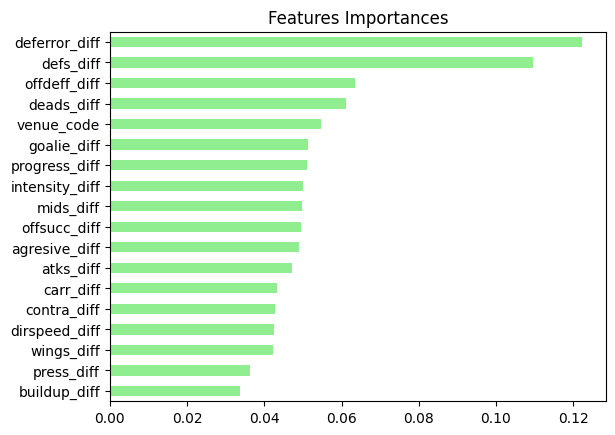

In [11]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)

model,pred,info=make_predictions(splited ,rf,feature_names,plot_imp=True,plot_roc=False)

[('standardscaler', StandardScaler()), ('svc', SVC(probability=True))]
0.7201834862385321
[[ 44  34]
 [ 27 113]]
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       140
           1       0.62      0.56      0.59        78

    accuracy                           0.72       218
   macro avg       0.69      0.69      0.69       218
weighted avg       0.72      0.72      0.72       218

AUCscore: 0.7812271062271062


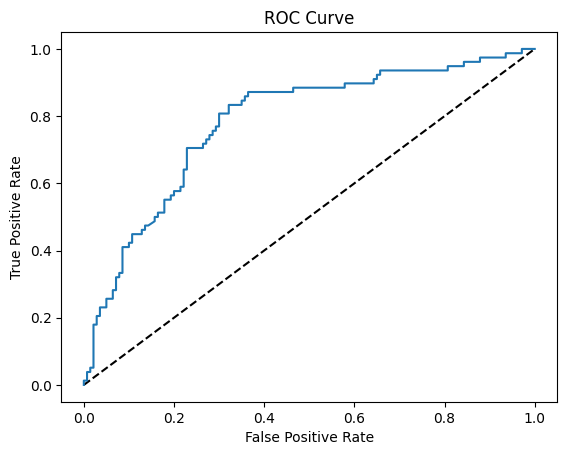

In [12]:
from sklearn.svm import SVC

svm= SVC(probability=True)

# Specify the hyperparameter space
parameters = {'svc__C':[1, 10, 100],
              'svc__gamma':[0.1, 0.01]}

model,pred,info=make_predictions(splited ,svm,feature_names,plot_imp=True,plot_roc=True,scale=True,grid_params=parameters)


c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\krawc\OneDrive\Documents\code\pythons\predictor\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\krawc\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 546, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\krawc\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1022, in __init__
    self._execute_child(args, executable, preexec_f

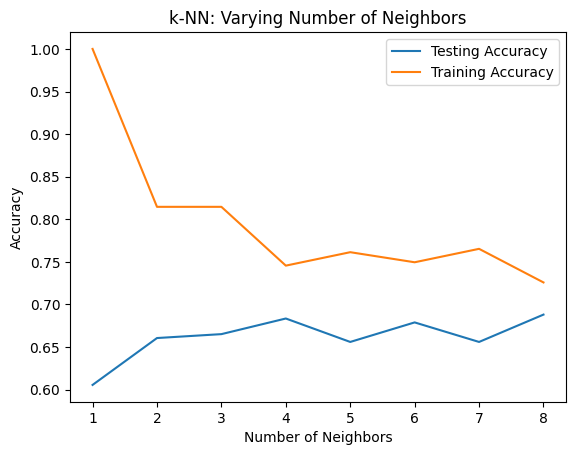

0.6788990825688074
[[ 31  47]
 [ 23 117]]
              precision    recall  f1-score   support

           0       0.71      0.84      0.77       140
           1       0.57      0.40      0.47        78

    accuracy                           0.68       218
   macro avg       0.64      0.62      0.62       218
weighted avg       0.66      0.68      0.66       218

AUCscore: 0.6846153846153846


In [13]:
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

def how_many_neighbours(data):
    X_train, X_test, y_train, y_test = data
    # Setup arrays to store train and test accuracies
    neighbors = np.arange(1, 9)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))

    # Loop over different values of k
    for i, k in enumerate(neighbors):
        # Setup a k-NN Classifier with k neighbors: knn
        knn = KNeighborsClassifier(n_neighbors=k)

        # Fit the classifier to the training data
        knn.fit(X_train,y_train)
        
        #Compute accuracy on the training set
        train_accuracy[i] = knn.score(X_train,y_train)
        #Compute accuracy on the testing set
        test_accuracy[i] = knn.score(X_test, y_test)

    # Generate plot
    plt.title('k-NN: Varying Number of Neighbors')
    plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
    plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
    plt.legend()
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.show()

how_many_neighbours(splited)

knn = KNeighborsClassifier(n_neighbors=6)

model,pred,info=make_predictions(splited ,knn,feature_names,plot_imp=True,plot_roc=False)

[('standardscaler', StandardScaler()), ('logisticregression', LogisticRegression())]
0.7568807339449541
[[ 48  30]
 [ 23 117]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       140
           1       0.68      0.62      0.64        78

    accuracy                           0.76       218
   macro avg       0.74      0.73      0.73       218
weighted avg       0.75      0.76      0.75       218

AUCscore: 0.8186813186813187


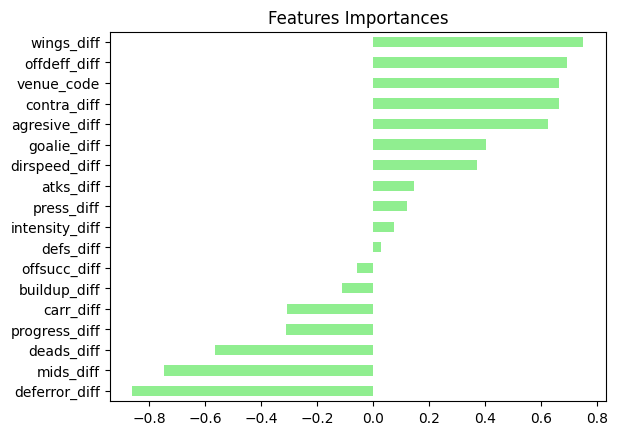

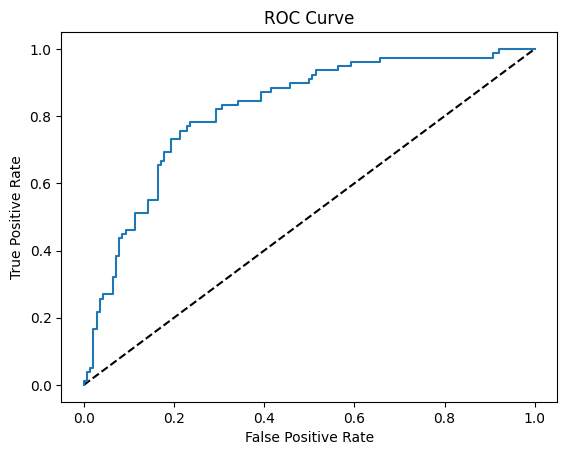

In [14]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lreg=LogisticRegression()

model,pred,info=make_predictions(splited ,lreg,feature_names,plot_imp=True,plot_roc=True,scale=True,cust_threshold=None)

# befroe rolling 0.7236842105263158
# [[110  24]
#  [ 39  55]]


[('standardscaler', StandardScaler()), ('logisticregression', LogisticRegression())]
0.7706422018348624
[[ 34  44]
 [ 12 128]]
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       140
           1       0.74      0.44      0.55        78

    accuracy                           0.74       218
   macro avg       0.74      0.68      0.68       218
weighted avg       0.74      0.74      0.72       218

AUCscore: 0.8161172161172161


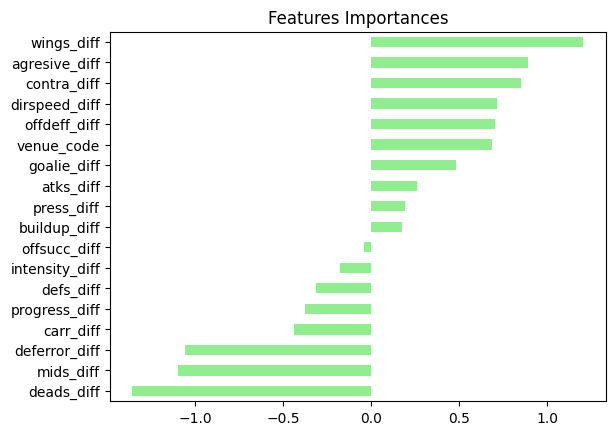

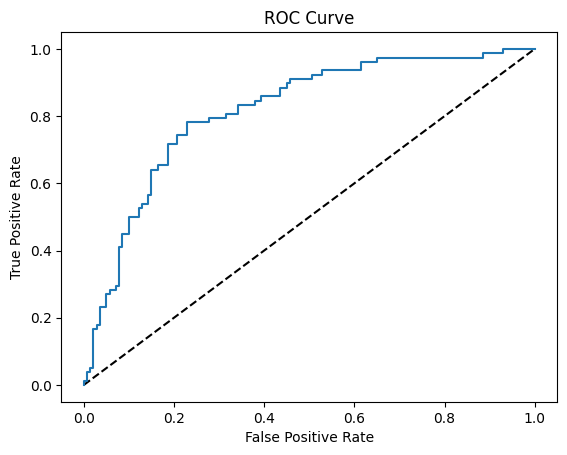

In [15]:
# GridSearch
import warnings
warnings.filterwarnings("ignore")
lreg=LogisticRegression()
# Specify the hyperparameter space
# parameters = {'logisticregression__C': np.logspace(-5, 8, 15)}
parameters = [    
    {'logisticregression__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'logisticregression__C' : np.logspace(-4, 4, 20),
    # 'logisticregression__solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    # 'logisticregression__max_iter' : [100, 1000,2500, 5000]
    }]

model,pred,info=make_predictions(splited ,lreg,feature_names,plot_imp=True,plot_roc=True,scale=True,grid_params=parameters,cust_threshold=0.6)

# 0.75 {'lreg__C': 0.23357214690901212, 'lreg__penalty': 'l2'}
# max 0.77/0.74 przy trsh=0.6


0.6926605504587156
[[ 42  36]
 [ 31 109]]
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       140
           1       0.58      0.54      0.56        78

    accuracy                           0.69       218
   macro avg       0.66      0.66      0.66       218
weighted avg       0.69      0.69      0.69       218

AUCscore: 0.690018315018315


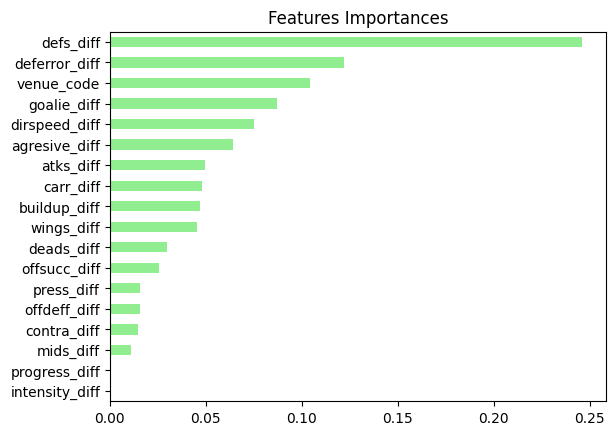

In [16]:
#CART - Classification and Regression Trees 
# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=6, random_state=1, criterion='entropy') #, criterion='gini'

model,pred,info=make_predictions(splited ,dt,feature_names,plot_imp=True,plot_roc=False)


In [17]:
# Import VotingClassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier

# Instantiate clses
SEED=1 # Set seed for reproducibility
lr = LogisticRegression(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=2)
dt = DecisionTreeClassifier(min_samples_leaf=0.13, random_state=SEED)

# Define the list classifiers
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

# Instantiate a VotingClassifier vc 
vc = VotingClassifier(estimators=classifiers)     

model,pred,info=make_predictions(splited ,vc,feature_names,plot_imp=True,plot_roc=False)

0.7247706422018348
[[ 38  40]
 [ 20 120]]
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       140
           1       0.66      0.49      0.56        78

    accuracy                           0.72       218
   macro avg       0.70      0.67      0.68       218
weighted avg       0.72      0.72      0.71       218



In [18]:
# Import BaggingClassifier
from sklearn.ensemble import BaggingClassifier

# Instantiate dt
dt = DecisionTreeClassifier(random_state=1)
# 50 drzew z rozna bootsrapowana data glosuje -> tworzy sie 50 tych samych modeli dopasowanych do innej kombincji danych
bc = BaggingClassifier(base_estimator=dt, n_estimators=50, random_state=1, oob_score=True)

model,pred,info=make_predictions(splited ,bc,feature_names,plot_imp=True,plot_roc=False)


0.7155963302752294
[[ 40  38]
 [ 24 116]]
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       140
           1       0.62      0.51      0.56        78

    accuracy                           0.72       218
   macro avg       0.69      0.67      0.68       218
weighted avg       0.71      0.72      0.71       218

AUCscore: 0.7371336996336997
OOBscore: 0.6982248520710059


0.6605504587155964
[[ 36  42]
 [ 32 108]]
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       140
           1       0.53      0.46      0.49        78

    accuracy                           0.66       218
   macro avg       0.62      0.62      0.62       218
weighted avg       0.65      0.66      0.65       218

AUCscore: 0.6745421245421246


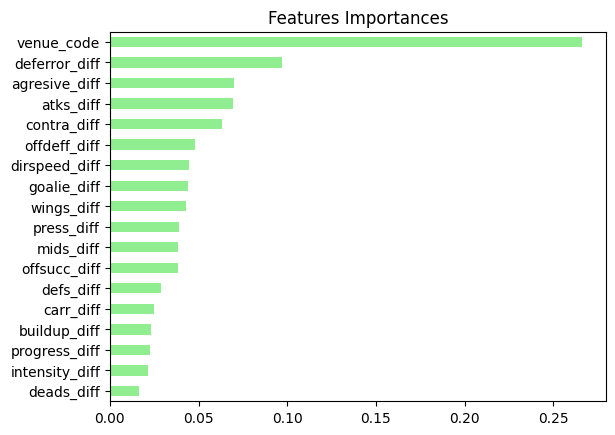

In [19]:
# Import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# Instantiate dt
dt = DecisionTreeClassifier(max_depth=2, random_state=1)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=200, random_state=1)

model,pred,info=make_predictions(splited ,ada,feature_names,plot_imp=True,plot_roc=False)


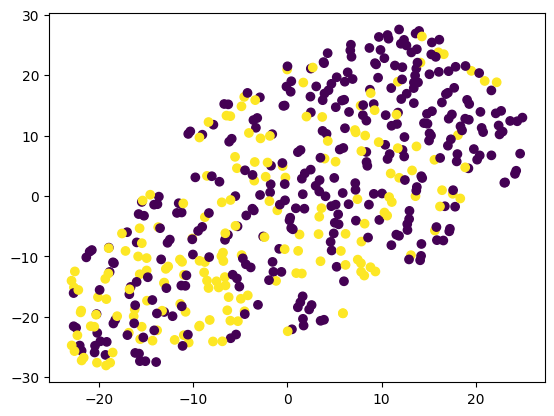

In [20]:
def plot_tsne(data):
    X_train, X_test, y_train, y_test = data

    # Import TSNE
    from sklearn.manifold import TSNE

    # Create a TSNE instance: model
    model = TSNE(learning_rate=200)
    # Apply fit_transform to samples: tsne_features
    tsne_features = model.fit_transform(X_train)

    # Select the 0th feature: xs
    xs = tsne_features[:,0]
    # Select the 1st feature: ys
    ys = tsne_features[:,1]

    # Scatter plot, coloring by variety_numbers
    plt.scatter(xs,ys,c=y_train)
    plt.show()
plot_tsne(splited)

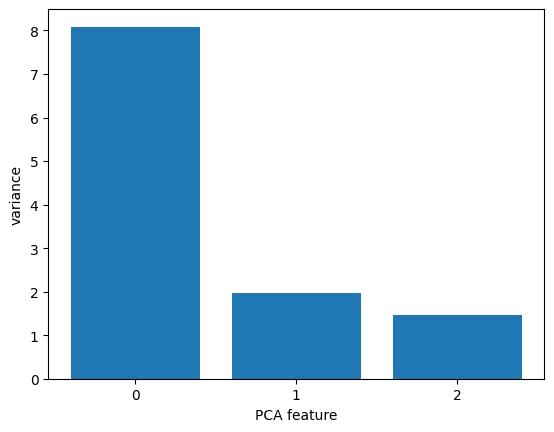

(507, 18)
(507, 3)


,goalie_diff,defs_diff,mids_diff,atks_diff,offdeff_diff,intensity_diff,dirspeed_diff,deads_diff,press_diff,contra_diff,buildup_diff,progress_diff,carr_diff,wings_diff,agresive_diff,deferror_diff,offsucc_diff,venue_code
PC1,-0.237320,-0.270519,-0.325356,-0.117606,-0.254203,-0.337405,0.242412,0.335457,-0.264201,-0.194021,-0.315894,-0.019926,0.183013,0.257268,0.029095,0.164046,-0.256657,-0.010561
PC2,0.290242,-0.082315,-0.109166,0.080951,-0.007791,0.087380,-0.321729,-0.095289,-0.264451,-0.072114,0.102108,-0.453109,0.434679,0.225488,-0.479463,-0.048854,0.072604,-0.045021
PC3,-0.128842,0.056080,0.052953,0.257748,-0.440059,-0.019821,0.073707,0.066367,-0.054484,0.475804,0.050624,-0.562045,-0.005370,-0.312974,0.215850,0.001586,-0.120749,-0.012845


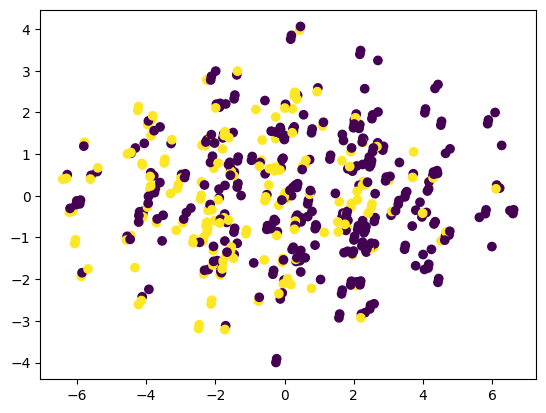

In [21]:
def plot_pca(data,n_components=3):
    X_train, X_test, y_train, y_test = data
    # how many intrinsic dimensions you have to set n_components - idealy to intrinsic dimention


    from sklearn.decomposition import PCA

    # Create scaler: scaler
    scaler = StandardScaler()
    # Create a PCA instance: pca
    if n_components:
        pca = PCA(n_components=n_components)
    else:
        pca = PCA()

    # Create pipeline: pipeline
    pipeline = make_pipeline(scaler,pca)
    # Fit the pipeline to 'samples'
    pipeline.fit(X_train)

    # Transform the scaled samples: pca_features
    pca_features = pipeline.transform(X_train)


    # Plot the explained variances
    features = range(pca.n_components_)
    plt.bar(features, pca.explained_variance_)
    plt.xlabel('PCA feature')
    plt.ylabel('variance')
    plt.xticks(features)
    plt.show()

    # Print the shape of pca_features
    print(X_train.shape)
    print(pca_features.shape)

    # This information is included in the pca attribute: components_. As described in the documentation, 
    # pca.components_ outputs an array of [n_components, n_features], 
    # so to get how components are linearly related with the different features you have to:
    #wychodzi na to ze PC sa skorelowane z kazdym feature i sa ich oszacowaniem, wiec nie wiadomo z ktorego zrezygnowac
    # Dump components relations with features:
    display(pd.DataFrame(pca.components_,columns=feature_names,index = [f'PC{x}' for x in range(1,n_components+1)]))

    # Select the 0th feature: xs
    xs = pca_features[:,0]
    # Select the 1st feature: ys
    ys = pca_features[:,1]
    # Scatter plot, coloring by variety_numbers
    plt.scatter(xs,ys,c=y_train)
    plt.show()
    
plot_pca(splited)

,opponent,team,date,time,round,day,venue,result,gf,ga,target
0,Arsenal,Aston Villa,2022-08-31,19:30:00,Matchweek 5,Wed,Away,L,1,2,0
1,Arsenal,Aston Villa,2023-02-18,12:30:00,Matchweek 24,Sat,Home,L,2,4,0
2,Arsenal,Bournemouth,2022-08-20,17:30:00,Matchweek 3,Sat,Home,L,0,3,0
3,Arsenal,Bournemouth,2023-03-04,15:00:00,Matchweek 26,Sat,Away,L,2,3,0
4,Arsenal,Brentford,2022-09-18,12:00:00,Matchweek 8,Sun,Home,L,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...
755,Wolves,Southampton,2023-02-11,15:00:00,Matchweek 23,Sat,Home,L,1,2,0
756,Wolves,Tottenham,2022-08-20,12:30:00,Matchweek 3,Sat,Home,W,1,0,1
757,Wolves,Tottenham,2023-03-04,15:00:00,Matchweek 26,Sat,Away,L,0,1,0
758,Wolves,West Ham,2022-10-01,17:30:00,Matchweek 9,Sat,Home,W,2,0,1


In [32]:
# export_model(clf,'modelname')

fin=append_preds(full_w_outs.iloc[:,:11],full_w_outs,feature_names,model)
fin
# fin.to_csv('match_w_pred_2223diff_trsh.csv')

,opponent,team,date,time,round,day,venue,result,gf,ga,target,y_pred,y_prob
0,Arsenal,Aston Villa,2022-08-31,19:30:00,Matchweek 5,Wed,Away,L,1,2,0,0,0.452852
1,Arsenal,Aston Villa,2023-02-18,12:30:00,Matchweek 24,Sat,Home,L,2,4,0,0,0.469568
2,Arsenal,Bournemouth,2022-08-20,17:30:00,Matchweek 3,Sat,Home,L,0,3,0,0,0.274318
3,Arsenal,Bournemouth,2023-03-04,15:00:00,Matchweek 26,Sat,Away,L,2,3,0,0,0.165115
4,Arsenal,Brentford,2022-09-18,12:00:00,Matchweek 8,Sun,Home,L,0,3,0,0,0.330117
...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,Wolves,Southampton,2023-02-11,15:00:00,Matchweek 23,Sat,Home,L,1,2,0,0,0.415258
756,Wolves,Tottenham,2022-08-20,12:30:00,Matchweek 3,Sat,Home,W,1,0,1,0,0.523535
757,Wolves,Tottenham,2023-03-04,15:00:00,Matchweek 26,Sat,Away,L,0,1,0,0,0.473132
758,Wolves,West Ham,2022-10-01,17:30:00,Matchweek 9,Sat,Home,W,2,0,1,0,0.482124
